## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [1]:
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from data_classes import HealthData, PopData
import numpy as np
import requests
import pandas as pd
from os import makedirs, path, listdir
from tqdm import tqdm
import zipfile as zpf
import matplotlib.pyplot as plt
import xlrd
from openpyxl import load_workbook
import wandb

## Code

### Daily mortality
Daily mortality data at regional scale. Here we select for the Greater London region using region code E12000007.

In [27]:
region_code = "E12000007"
start_year = 1981
end_year = 2018

In [28]:
urls = {}
urls.update(dict.fromkeys(list(range(1981, 2014+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/005459dailydeathoccurrencesenglandregionsofenglandandwales1970to2014/dailydeathoccurrences19702014.zip"))
urls.update(dict.fromkeys(list(range(2013, 2017+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/009728dailydeathoccurrencesregionsofenglandandwales2013to2016/dailydeathoccurrences20132017.xls"))
urls.update(dict.fromkeys(list(range(2015, 2018+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11189dailydeathsenglishregionsandwales2015to2018occurrences/dailydeathsfinal.xlsx"))

In [5]:
mortality = HealthData()

In [2]:
#mortality.download_and_log(region_code, start_year, end_year, urls)

In [6]:
daily_df = mortality.read("mortality-raw")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [7]:
daily_df.shape

(13879, 1)

In [9]:
daily_df.columns

Index(['deaths'], dtype='object')

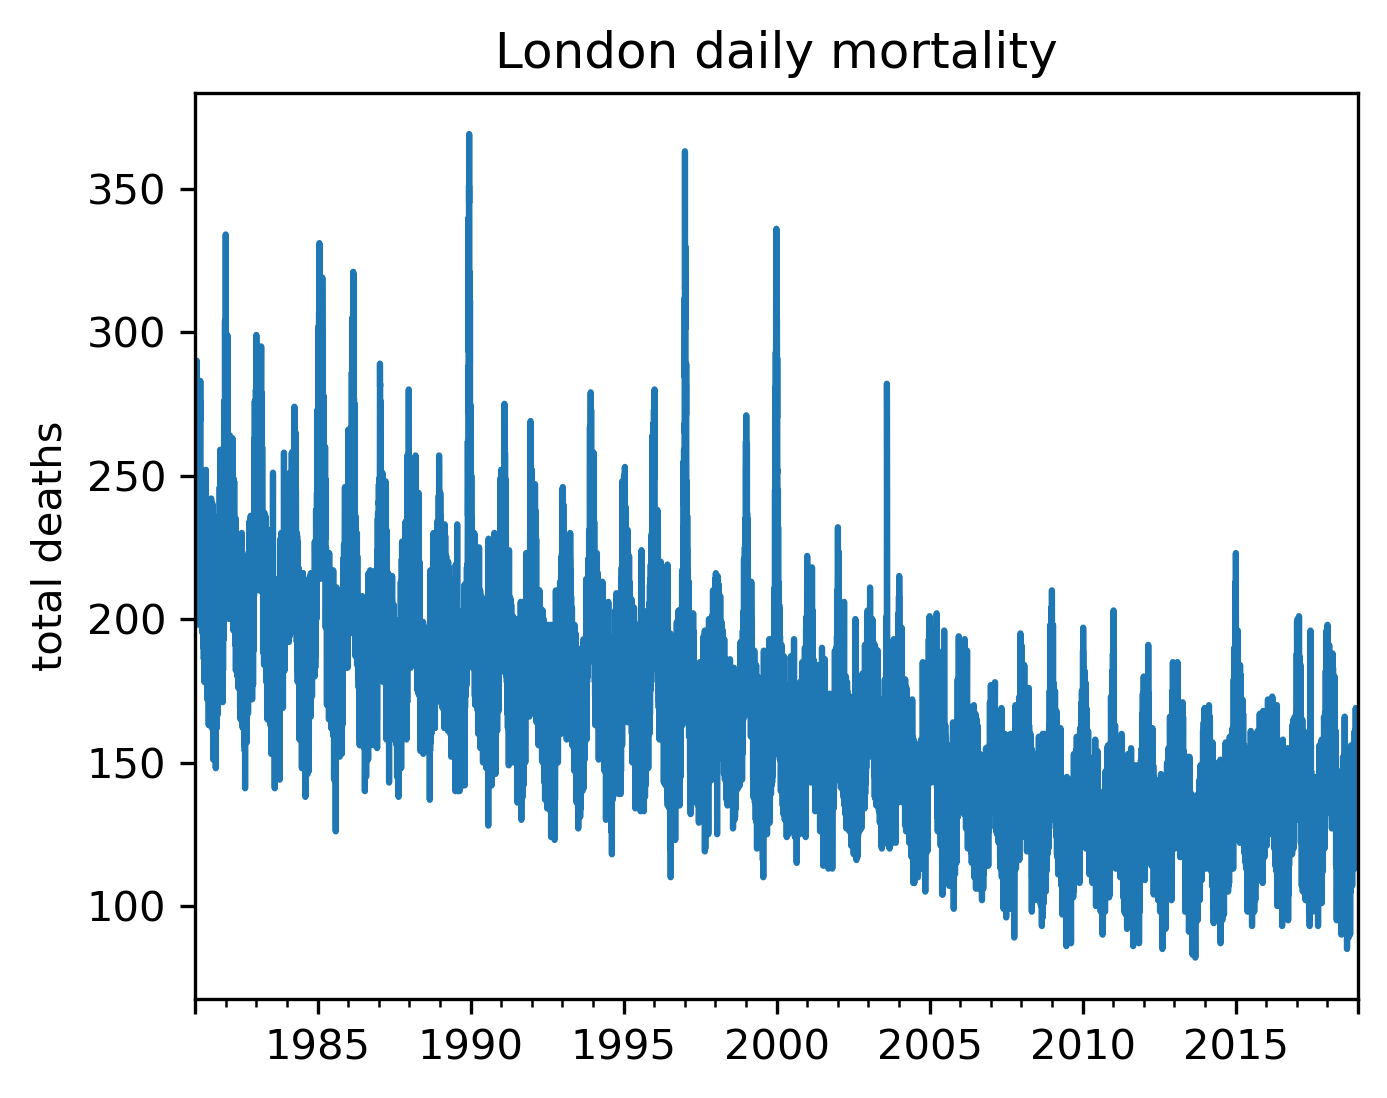

In [21]:
plt.figure(figsize=(5,4), dpi=300)
daily_df['deaths'].plot(legend=False, title="London daily mortality").set_ylabel("total deaths")
plt.show()

### Population data

#### Download & process the population data

In [12]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
region_name = "London"
pop_data = PopData()

In [11]:
#pop_data.download_and_log(url, region_name)

#### Load the data

In [13]:
population_df = pop_data.read("population-raw")
population_df.shape

(39, 1)

#### Plot the dataframe

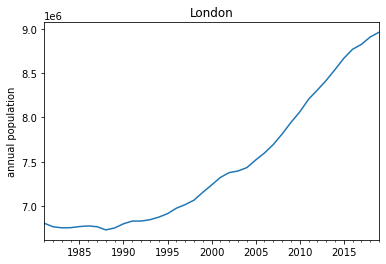

In [62]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Linear interpolation of annual data

In [4]:
key = "D"
method = "linear"

In [5]:
linear_df = pop_data.resample_time_and_log(key, method)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [6]:
linear_df = pop_data.read("population-resample")

In [7]:
linear_df.shape

(13880, 1)

### Calculating deaths as a fraction of population

Daily deaths

In [8]:
df = mortality.scale_per_capita_and_log()

In [14]:
df = mortality.read("mortality-scaled")

In [15]:
df.shape

(13698, 1)

In [16]:
df.columns

Index(['deaths'], dtype='object')

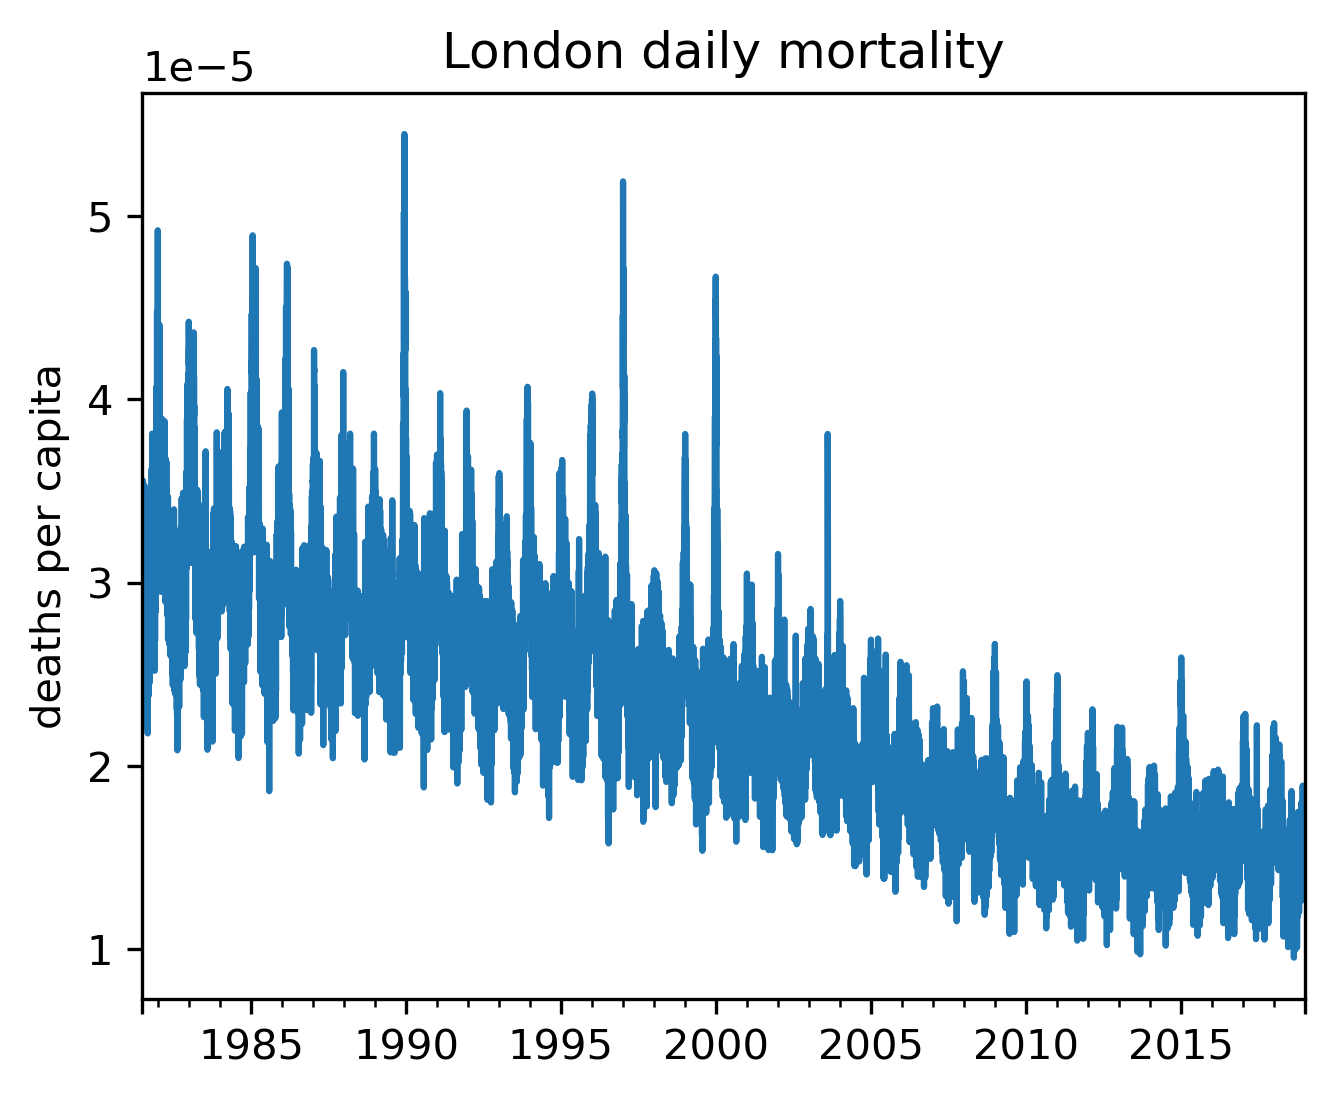

In [20]:
plt.figure(figsize=(5,4), dpi=300)
df["deaths"].plot(legend=False, title="London daily mortality").set_ylabel("deaths per capita")
plt.show()